This notebook was designed to predict the credit risk and tune the hyperparameters to improve accuracy.

# **1. Introduction**

**Context**
* The original dataset contains 1000 entries with 20 categorial/symbolic 
attributes. 
* In this dataset, each entry represents a person who takes a credit by a bank. 
* Each person is classified as good or bad credit risks according to the set of attributes. 


**Content**

It is almost impossible to understand the original dataset due to its complicated system of categories and symbols. Thus, I got this dataset from Kaggle as a readable CSV file. Several columns are simply ignored.

The available attributes in that dataset are:
1. Age (numeric)
2. Sex (text: male, female)
3. Job (numeric: 0 - unskilled and non-resident, 1 - unskilled and resident, 2 - skilled, 3 - highly skilled)
4. Housing (text: own, rent, or free)
5. Saving accounts (text - little, moderate, quite rich, rich)
6. Checking account (numeric, in DM - Deutsch Mark)
7. Credit amount (numeric, in DM)
8. Duration (numeric, in month)
9. Purpose(text: car, furniture/equipment, radio/TV, domestic appliances, repairs, education, business, vacation/others
10. Risk (Value target - Good or Bad Risk)

# **2. Librarys**

Importing Librarys

Importing Dataset

In [ ]:
!pip install plotly

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#Load the librarys
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# it's a library that we work with plotly

import plotly.graph_objs as go
import plotly.io as pio
from collections import Counter
import plotly.figure_factory as ff
import plotly.tools as tls  
pio.renderers.default = 'colab'  # Enable the Plotly Colab renderer


from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV                                         # to split the data
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, confusion_matrix, classification_report, fbeta_score     # to evaluate our model

# Algorithmns models to be compared
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier


import warnings

from sklearn.exceptions import ConvergenceWarning
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter("ignore", category=ConvergenceWarning)

pd.pandas.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)



In [ ]:
#Importing the data
df = pd.read_csv("german_credit_data.csv",index_col=0)
df.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,49,male,1,own,little,NaN,2096,12,education,good
3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,53,male,2,free,little,little,4870,24,car,bad


In [ ]:
#Looking null values
df.isnull().sum()

Age                   0
Sex                   0
Job                   0
Housing               0
Saving accounts     183
Checking account    394
Credit amount         0
Duration              0
Purpose               0
Risk                  0
dtype: int64

In [ ]:
#Searching for Missings,type of data having null and also known the shape of data
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Age               1000 non-null   int64 
 1   Sex               1000 non-null   object
 2   Job               1000 non-null   int64 
 3   Housing           1000 non-null   object
 4   Saving accounts   817 non-null    object
 5   Checking account  606 non-null    object
 6   Credit amount     1000 non-null   int64 
 7   Duration          1000 non-null   int64 
 8   Purpose           1000 non-null   object
 9   Risk              1000 non-null   object
dtypes: int64(4), object(6)
memory usage: 85.9+ KB
None


# **Exploratory Data Analysis**

**Categorical Variable Analysis**

In [ ]:
#Profiling Categorical Columns
categ_cols = [col for col in df.columns if df[col].dtypes == 'O']

for col in categ_cols:
    print(df[col].value_counts(), "\n\n")

male      690
female    310
Name: Sex, dtype: int64 


own     713
rent    179
free    108
Name: Housing, dtype: int64 


little        603
moderate      103
quite rich     63
rich           48
Name: Saving accounts, dtype: int64 


little      274
moderate    269
rich         63
Name: Checking account, dtype: int64 


car                    337
radio/TV               280
furniture/equipment    181
business                97
education               59
repairs                 22
domestic appliances     12
vacation/others         12
Name: Purpose, dtype: int64 


good    700
bad     300
Name: Risk, dtype: int64 




** 4. Some explorations**

* Starting by distribuition of column Age.
* Some Seaborn graphical
* Columns crossing

In [ ]:
traceGood = go.Bar(
            x = df[df["Risk"]== 'good']["Risk"].value_counts().index.values,
            y = df[df["Risk"]== 'good']["Risk"].value_counts().values,
            name='Good credit')

traceBad = go.Bar(
            x = df[df["Risk"]== 'bad']["Risk"].value_counts().index.values,
            y = df[df["Risk"]== 'bad']["Risk"].value_counts().values,
            name='Bad credit')


data = [traceGood, traceBad]
layout = go.Layout(
    yaxis=dict(
        title='Count'
    ),
    xaxis=dict(
        title='Risk Variable'
    ),
    title='Risk variable distribution'
)

fig = go.Figure(data=data, layout=layout)
fig.data[0].marker.line.width = 4
fig.data[0].marker.color = "green"
fig.data[1].marker.line.width = 4
fig.data[1].marker.color = "red"

fig.show()


**Numerical Variable Analysis**

Number of Numerical Variable:  4


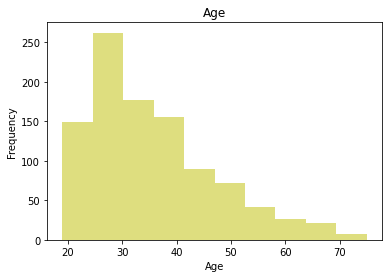

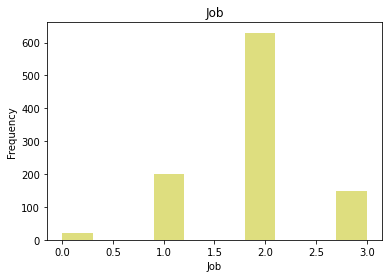

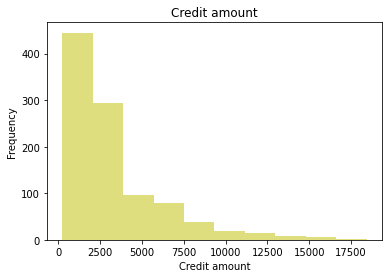

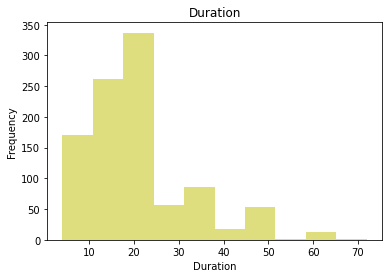

4 variables have been plotted


In [ ]:
num_cols = [col for col in df.columns if df[col].dtypes != 'O' and col not in "Id"]
print('Number of Numerical Variable: ', len(num_cols))


def hist_for_nums(data, numeric_cols):
    col_counter = 0
    data = data.copy()
    for col in numeric_cols:
        data[col].plot.hist(alpha=0.5, color='y')
        plt.xlabel(col)
        plt.title(col)
        plt.show()
        col_counter += 1
    print(col_counter, "variables have been plotted")


hist_for_nums(df, num_cols)

**Observing the distribution of risk over age**

In [ ]:
df_good = df.loc[df["Risk"] == 'good']['Age'].values.tolist()
df_bad = df.loc[df["Risk"] == 'bad']['Age'].values.tolist()
df_age = df['Age'].values.tolist()

#First plot
trace0 = go.Histogram(
    x=df_good,
    histnorm='probability',
    name="Good Credit"
)
#Second plot
trace1 = go.Histogram(
    x=df_bad,
    histnorm='probability',
    name="Bad Credit"
)
#Third plot
trace2 = go.Histogram(
    x=df_age,
    histnorm='probability',
    name="Overall Age"
)

#Creating the grid
fig = tls.make_subplots(rows=2, cols=2, specs=[[{}, {}], [{'colspan': 2}, None]],
                          subplot_titles=('Good','Bad', 'General Distribuition'))

#setting the figs
fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 1, 2)
fig.append_trace(trace2, 2, 1)

fig['layout'].update(showlegend=True, title='Age Distribuition', bargap=0.05)
fig.show()

/usr/local/lib/python3.9/dist-packages/plotly/tools.py:461: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



**Seeing together in graphs accordings to Frequency and Count**

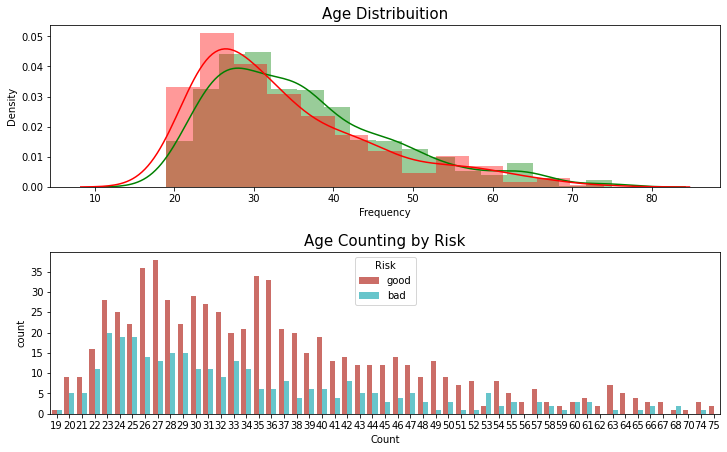

In [ ]:
df_good = df[df["Risk"] == 'good']
df_bad = df[df["Risk"] == 'bad']

fig, ax = plt.subplots(nrows=2, figsize=(12,8))
plt.subplots_adjust(hspace = 0.4, top = 0.8)

g1 = sns.distplot(df_good["Age"], ax=ax[0], 
             color="g")
g1 = sns.distplot(df_bad["Age"], ax=ax[0], 
             color='r')
g1.set_title("Age Distribuition", fontsize=15)
g1.set_xlabel("Age")
g1.set_xlabel("Frequency")

g2 = sns.countplot(x="Age",data=df, 
              palette="hls", ax=ax[1], 
              hue = "Risk")
g2.set_title("Age Counting by Risk", fontsize=15)
g2.set_xlabel("Age")
g2.set_xlabel("Count")
plt.show()

It can be seen that the "Age" variable is very important. Because of the need, I create categorical variables according to the Age variable. And let's re-create df_bad dataframes and df_good that we created.

In [ ]:
#Creating an categorical variable to handle with the Age variable using interval
interval = (18, 25, 35, 60, 120)

cats = ['Student', 'Young', 'Adult', 'Senior']
df["Age_cat"] = pd.cut(df.Age, interval, labels=cats)

# And let's re-create "df_bad" dataframes with "df_good" we created.
df_good = df[df["Risk"] == 'good']
df_bad = df[df["Risk"] == 'bad']

Let's visualize it again according to the newly created

In [ ]:
trace0 = go.Box(
    y=df_good["Credit amount"],
    x=df_good["Age_cat"],
    name='Good credit',
    marker=dict(
        color='LightSkyBlue'
    )
)

trace1 = go.Box(
    y=df_bad['Credit amount'],
    x=df_bad['Age_cat'],
    name='Bad credit',
    marker=dict(
        color='DarkSlateGrey'
    )
)
    
data = [trace0, trace1]

layout = go.Layout(
    yaxis=dict(
        title='Credit Amount (US Dollar)',
        zeroline=False
    ),
    xaxis=dict(
        title='Age Categorical'
    ),
    boxmode='group'
)
fig = go.Figure(data=data, layout=layout)

fig.show()

Now let's look at the breakdown of Leaseholder and Rent by Risk

In [ ]:
#First plot
trace0 = go.Bar(
    x = df[df["Risk"]== 'good']["Housing"].value_counts().index.values,
    y = df[df["Risk"]== 'good']["Housing"].value_counts().values,
    name='Good credit'
)

#Second plot
trace1 = go.Bar(
    x = df[df["Risk"]== 'bad']["Housing"].value_counts().index.values,
    y = df[df["Risk"]== 'bad']["Housing"].value_counts().values,
    name="Bad Credit"
)

data = [trace0, trace1]

layout = go.Layout(
    title='Housing Distribuition'
)


fig = go.Figure(data=data, layout=layout)
fig.data[0].marker.line.width = 4
fig.data[0].marker.color = "green"
fig.data[1].marker.line.width = 4
fig.data[1].marker.color = "red"

fig.show()

**Distribuition of Credit Amount by Housing visualization**

Focus on the highest values ​​come from the category of "free" and we have a different distribution by Risk.

In [ ]:
# Create a violin trace for the 'good' credit group
trace0 = go.Violin(
    x=df_good['Housing'],
    y=df_good['Credit amount'],
    name='Good credit',
    legendgroup='Good Credit',
    scalegroup='No',
    side='negative',
    box={'visible': True},
    meanline={'visible': True},
    line={'color': '#673D43'}
)

# Create a violin trace for the 'bad' credit group
trace1 = go.Violin(
    x=df_bad['Housing'],
    y=df_bad['Credit amount'],
    name='Bad credit',
    legendgroup='Bad Credit',
    scalegroup='No',
    side='positive',
    box={'visible': True},
    meanline={'visible': True},
    line={'color': '#1f77b4'}
)

# Combine the traces into a list
data = [trace0, trace1]

# Define the layout options
layout = go.Layout(
    title='Housing Distribution',
    yaxis={'zeroline': False},
    violingap=0,
    violinmode='overlay'
)

# Create a figure object and modify the markers
fig = go.Figure(data=data, layout=layout)
fig.data[0].marker.line.width = 4
fig.data[0].marker.color = '#673D43'
fig.data[1].marker.line.width = 4
fig.data[1].marker.color = '#1f77b4'

# Show the figure
fig.show()

Interestingly, highest values come from category "free" and we have a different distribuition by Risk.

**Risk distribution by Sex**

In [ ]:
#Risk distribution by Sex
#First plot
trace0 = go.Bar(
    x = df[df["Risk"]== 'good']["Sex"].value_counts().index.values,
    y = df[df["Risk"]== 'good']["Sex"].value_counts().values,
    name='Good credit'
)

#First plot 2
trace1 = go.Bar(
    x = df[df["Risk"]== 'bad']["Sex"].value_counts().index.values,
    y = df[df["Risk"]== 'bad']["Sex"].value_counts().values,
    name="Bad Credit"
)

#Second plot
trace2 = go.Box(
    x = df[df["Risk"]== 'good']["Sex"],
    y = df[df["Risk"]== 'good']["Credit amount"],
    name=trace0.name
)

#Second plot 2
trace3 = go.Box(
    x = df[df["Risk"]== 'bad']["Sex"],
    y = df[df["Risk"]== 'bad']["Credit amount"],
    name=trace1.name
)

data = [trace0, trace1, trace2,trace3]

fig = tls.make_subplots(rows=1, cols=2, 
                        subplot_titles=('Sex Count', 'Credit Amount by Sex'))

fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 2)
fig.append_trace(trace3, 1, 2)

fig['layout'].update(height=400, width=800, title='Sex Distribuition', boxmode='group')

fig.show()

/usr/local/lib/python3.9/dist-packages/plotly/tools.py:461: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



**Risk distribuition by Credit Amount**

In [ ]:
# Add histogram data
x1 = np.log(df_good['Credit amount']) 
x2 = np.log(df_bad["Credit amount"])

# Group data together
hist_data = [x1, x2]

group_labels = ['Good Credit', 'Bad Credit']
colors = ['rgb(0, 0, 100)', 'rgb(0, 200, 200)']

# Create distplot with custom bin_size
fig = ff.create_distplot(hist_data, group_labels, bin_size=.1, colors=colors)

# Plot!
fig.show()

**Risk Distribution by Job**

In [ ]:
#First plot
trace0 = go.Bar(
    x = df[df["Risk"]== 'good']["Job"].value_counts().index.values,
    y = df[df["Risk"]== 'good']["Job"].value_counts().values,
    name='Good credit Distribuition'
)

#Second plot
trace1 = go.Bar(
    x = df[df["Risk"]== 'bad']["Job"].value_counts().index.values,
    y = df[df["Risk"]== 'bad']["Job"].value_counts().values,
    name="Bad Credit Distribuition"
)

data = [trace0, trace1]

layout = go.Layout(
    title='Job Distribuition'
)

fig = go.Figure(data=data, layout=layout)
fig.data[0].marker.line.width = 4
fig.data[0].marker.color = "green"
fig.data[1].marker.line.width = 4
fig.data[1].marker.color = "red"

fig.show()

**Risk Distribution by Job and Credit Amount**

In [ ]:
trace0 = go.Box(
    x=df_good["Job"],
    y=df_good["Credit amount"],
    name='Good credit',
    marker=dict(
        color='LightSkyBlue')
)

trace1 = go.Box(
    x=df_bad['Job'],
    y=df_bad['Credit amount'],
    name='Bad credit',
    marker=dict(
        color='DarkSlateGrey')
)
    
data = [trace0, trace1]

layout = go.Layout(
    yaxis=dict(
        title='Credit Amount distribuition by Job',
        zeroline=False
    ),
    xaxis=dict(
        title='Age Categorical'
    ),
    boxmode='group'
)
fig = go.Figure(data=data, layout=layout)

fig.show()

**Risk Distribution by Job and Age**

In [ ]:
# Create a violin trace for the 'good' credit group
trace0 = go.Violin(
    x=df_good['Job'],
    y=df_good['Age'],
    name='Good credit',
    legendgroup='Good Credit',
    scalegroup='No',
    side='negative',
    box={'visible': True},
    meanline={'visible': True},
    line={'color': '#673D43'}
)

# Create a violin trace for the 'bad' credit group
trace1 = go.Violin(
    x=df_bad['Job'],
    y=df_bad['Age'],
    name='Bad credit',
    legendgroup='Bad Credit',
    scalegroup='No',
    side='positive',
    box={'visible': True},
    meanline={'visible': True},
    line={'color': '#1f77b4'}
)

# Combine the traces into a list
data = [trace0, trace1]

# Define the layout options
layout = go.Layout(
    title='Housing Distribution',
    yaxis={'zeroline': False},
    violingap=0,
    violinmode='overlay'
)

# Create a figure object and modify the markers
fig = go.Figure(data=data, layout=layout)
fig.data[0].marker.line.width = 4
fig.data[0].marker.color = '#673D43'
fig.data[1].marker.line.width = 4
fig.data[1].marker.color = '#1f77b4'

# Show the figure
fig.show()

**Risk Distribution by Savings Account**

In [ ]:
tracegood = go.Bar(
    x = df_good["Saving accounts"].value_counts().index.values,
    y = df_good["Saving accounts"].value_counts().values,
    name='Good credit'
)
tracebad = go.Bar(
    x = df_bad["Saving accounts"].value_counts().index.values,
    y = df_bad["Saving accounts"].value_counts().values,
    name='Bad credit'
)


box_1 = go.Box(
    x=df_good["Saving accounts"],
    y=df_good["Credit amount"],
    name='Good credit'
)
box_2 = go.Box(
    x=df_bad["Saving accounts"],
    y=df_bad["Credit amount"],
    name='Bad credit'
)

scat_1 = go.Box(
    x=df_good["Saving accounts"],
    y=df_good["Age"],
    name='Good credit'
)
scat_2 = go.Box(
    x=df_bad["Saving accounts"],
    y=df_bad["Age"],
    name='Bad credit'
)

data = [scat_1, scat_2, box_1, box_2, tracegood, tracebad]

fig = tls.make_subplots(rows=2, cols=2, specs=[[{}, {}], [{'colspan': 2}, None]],
                          subplot_titles=('Count Saving Accounts','Credit Amount by Savings Acc', 
                                          'Age by Saving accounts'))

fig.append_trace(tracegood, 1, 1)
fig.append_trace(tracebad, 1, 1)

fig.append_trace(box_2, 1, 2)
fig.append_trace(box_1, 1, 2)

fig.append_trace(scat_1, 2, 1)
fig.append_trace(scat_2, 2, 1)



fig['layout'].update(height=700, width=800, title='Saving Accounts Exploration', boxmode='group')

fig.show()


**Risk Distribution by products they bought using credit**

Values describe: 
Risk                 bad  good
Purpose                       
business              34    63
car                  106   231
domestic appliances    4     8
education             23    36
furniture/equipment   58   123
radio/TV              62   218
repairs                8    14
vacation/others        5     7


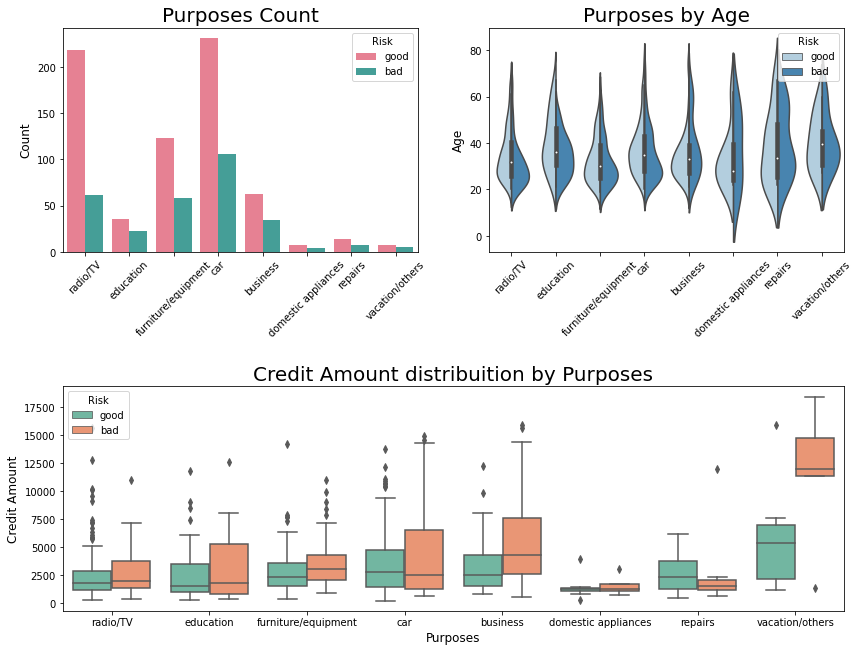

In [ ]:
print("Values describe: ")
print(pd.crosstab(df.Purpose, df.Risk))

plt.figure(figsize = (14,12))

plt.subplot(221)
g = sns.countplot(x="Purpose", data=df, 
              palette="husl", hue = "Risk")
g.set_xticklabels(g.get_xticklabels(),rotation=45)
g.set_xlabel("", fontsize=12)
g.set_ylabel("Count", fontsize=12)
g.set_title("Purposes Count", fontsize=20)

plt.subplot(222)
g1 = sns.violinplot(x="Purpose", y="Age", data=df, 
                    palette="Blues", hue = "Risk",split=True)
g1.set_xticklabels(g1.get_xticklabels(),rotation=45)
g1.set_xlabel("", fontsize=12)
g1.set_ylabel("Age", fontsize=12)
g1.set_title("Purposes by Age", fontsize=20)

plt.subplot(212)
g2 = sns.boxplot(x="Purpose", y="Credit amount", data=df, 
               palette="Set2", hue = "Risk")
g2.set_xlabel("Purposes", fontsize=12)
g2.set_ylabel("Credit Amount", fontsize=12)
g2.set_title("Credit Amount distribuition by Purposes", fontsize=20)

plt.subplots_adjust(hspace = 0.6, top = 0.8)

plt.show()

**Risk Distribution by Checking Account along with age , credit amount**

Total values of the most missing variable: 
Checking account
little      274
moderate    269
rich         63
Name: Checking account, dtype: int64


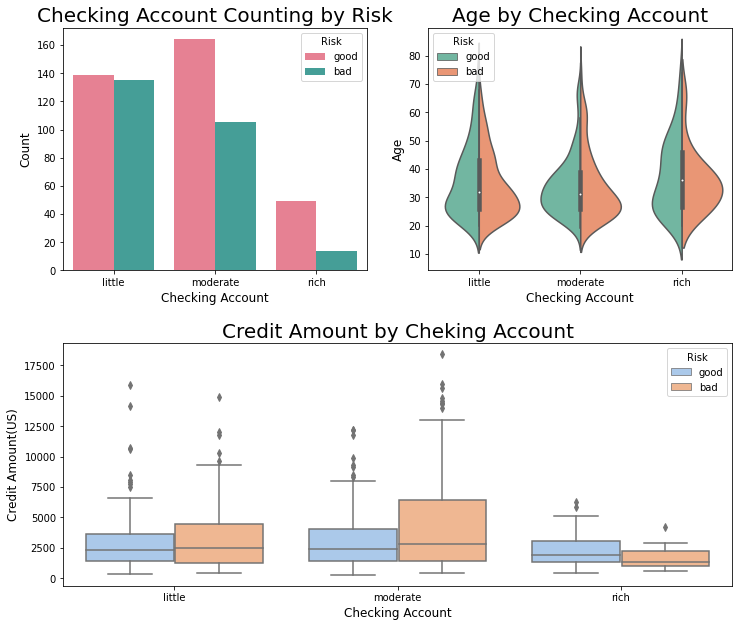

In [ ]:
print("Total values of the most missing variable: ")
print(df.groupby("Checking account")["Checking account"].count())

plt.figure(figsize = (12,10))

g = plt.subplot(221)
g = sns.countplot(x="Checking account", data=df, 
              palette="husl", hue="Risk")
g.set_xlabel("Checking Account", fontsize=12)
g.set_ylabel("Count", fontsize=12)
g.set_title("Checking Account Counting by Risk", fontsize=20)

g1 = plt.subplot(222)
g1 = sns.violinplot(x="Checking account", y="Age", data=df, palette="Set2", hue = "Risk",split=True)
g1.set_xlabel("Checking Account", fontsize=12)
g1.set_ylabel("Age", fontsize=12)
g1.set_title("Age by Checking Account", fontsize=20)

g2 = plt.subplot(212)
g2 = sns.boxplot(x="Checking account",y="Credit amount", data=df,hue='Risk',palette="pastel")
g2.set_xlabel("Checking Account", fontsize=12)
g2.set_ylabel("Credit Amount(US)", fontsize=12)
g2.set_title("Credit Amount by Cheking Account", fontsize=20)

plt.subplots_adjust(wspace = 0.2, hspace = 0.3, top = 0.9)

plt.show()
plt.show()

# **Data Prepcoressing & Feature Engineering**

**Missing Values Analysis**

In [ ]:
def missing_values_table(dataframe):
    variables_with_na = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]
    n_miss = dataframe[variables_with_na].isnull().sum().sort_values(ascending=False)
    ratio = (dataframe[variables_with_na].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])
    print(missing_df)
    return variables_with_na


missing_values_table(df)

                  n_miss  ratio
Checking account     394 39.400
Saving accounts      183 18.300


['Saving accounts', 'Checking account']

In [ ]:
#Filling missing values with mode
df["Saving accounts"].fillna(df['Saving accounts'].mode()[0], inplace=True)
df["Checking account"].fillna(df['Checking account'].mode()[0], inplace=True)

**Outliers Analysis**

In [ ]:
def outlier_thresholds(dataframe, variable):
    quartile1 = dataframe[variable].quantile(0.25)
    quartile3 = dataframe[variable].quantile(0.75)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit


def has_outliers(dataframe, num_col_names, plot=False):
    variable_names = []
    for col in num_col_names:
        low_limit, up_limit = outlier_thresholds(dataframe, col)
        if dataframe[(dataframe[col] > up_limit) | (dataframe[col] < low_limit)].any(axis=None):
            number_of_outliers = dataframe[(dataframe[col] > up_limit) | (dataframe[col] < low_limit)].shape[0]
            print(col, ":", number_of_outliers)
            variable_names.append(col)
            if plot:
                sns.boxplot(x=dataframe[col])
                plt.show()
    return variable_names


has_outliers(df, num_cols)

Age : 23
Job : 370
Credit amount : 72
Duration : 70


['Age', 'Job', 'Credit amount', 'Duration']

In [ ]:
def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit


for col in num_cols:
    replace_with_thresholds(df, col)

has_outliers(df, num_cols)

[]

In [ ]:
df.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk,Age_cat
0,64.500,male,2,own,little,little,1169.000,6,radio/TV,good,Senior
1,22.000,female,2,own,little,moderate,5951.000,42,radio/TV,bad,Student
2,49.000,male,2,own,little,little,2096.000,12,education,good,Adult
3,45.000,male,2,free,little,little,7882.000,42,furniture/equipment,good,Adult
4,53.000,male,2,free,little,little,4870.000,24,car,bad,Adult


In [ ]:
df["Risk"].value_counts()

good    700
bad     300
Name: Risk, dtype: int64

**Label Encoding & One-Hot Encoding**

In [ ]:
#Purpose to Dummies Variable
df = df.merge(pd.get_dummies(df.Purpose, drop_first=True, prefix='Purpose'), left_index=True, right_index=True)
#Sex feature in dummies
df = df.merge(pd.get_dummies(df.Sex, drop_first=True, prefix='Sex'), left_index=True, right_index=True)
# Housing get dummies
df = df.merge(pd.get_dummies(df.Housing, drop_first=True, prefix='Housing'), left_index=True, right_index=True)
# Housing get Saving Accounts
df = df.merge(pd.get_dummies(df["Saving accounts"], drop_first=True, prefix='Savings'), left_index=True, right_index=True)
# Housing get Risk
df = df.merge(pd.get_dummies(df.Risk, prefix='Risk'), left_index=True, right_index=True)
# Housing get Checking Account
df = df.merge(pd.get_dummies(df["Checking account"], drop_first=True, prefix='Check'), left_index=True, right_index=True)
# Housing get Age categorical
df = df.merge(pd.get_dummies(df["Age_cat"], drop_first=True, prefix='Age_cat'), left_index=True, right_index=True)

In [ ]:
droplist=["Sex","Housing","Saving accounts","Checking account","Purpose","Risk","Risk_good","Age_cat"]

df.drop(droplist, axis= 1, inplace = True)

**Standardization**

In [ ]:
# like_num = [col for col in df.columns if df[col].dtypes != 'O' and len(df[col].value_counts()) < 20]


# cols_need_scale = [col for col in df.columns if col not in "Id"
#                    and col not in "Risk"
#                    and col not in like_num]

# df[cols_need_scale].head()
# df[cols_need_scale].describe([0.05, 0.10, 0.25, 0.50, 0.75, 0.80, 0.90, 0.95, 0.99]).T
# hist_for_nums(df, cols_need_scale)


# def robust_scaler(variable):
#     var_median = variable.median()
#     quartile1 = variable.quantile(0.25)
#     quartile3 = variable.quantile(0.75)
#     interquantile_range = quartile3 - quartile1
#     if int(interquantile_range) == 0:
#         quartile1 = variable.quantile(0.05)
#         quartile3 = variable.quantile(0.95)
#         interquantile_range = quartile3 - quartile1
#         z = (variable - var_median) / interquantile_range
#         return round(z, 3)
#     else:
#         z = (variable - var_median) / interquantile_range
#     return round(z, 3)


# for col in cols_need_scale:
#     df[col] = robust_scaler(df[col])


# df[cols_need_scale].head()
# df[cols_need_scale].describe().T
# hist_for_nums(df, cols_need_scale)

**Correlation and Heatmap Analysis**

<AxesSubplot:>

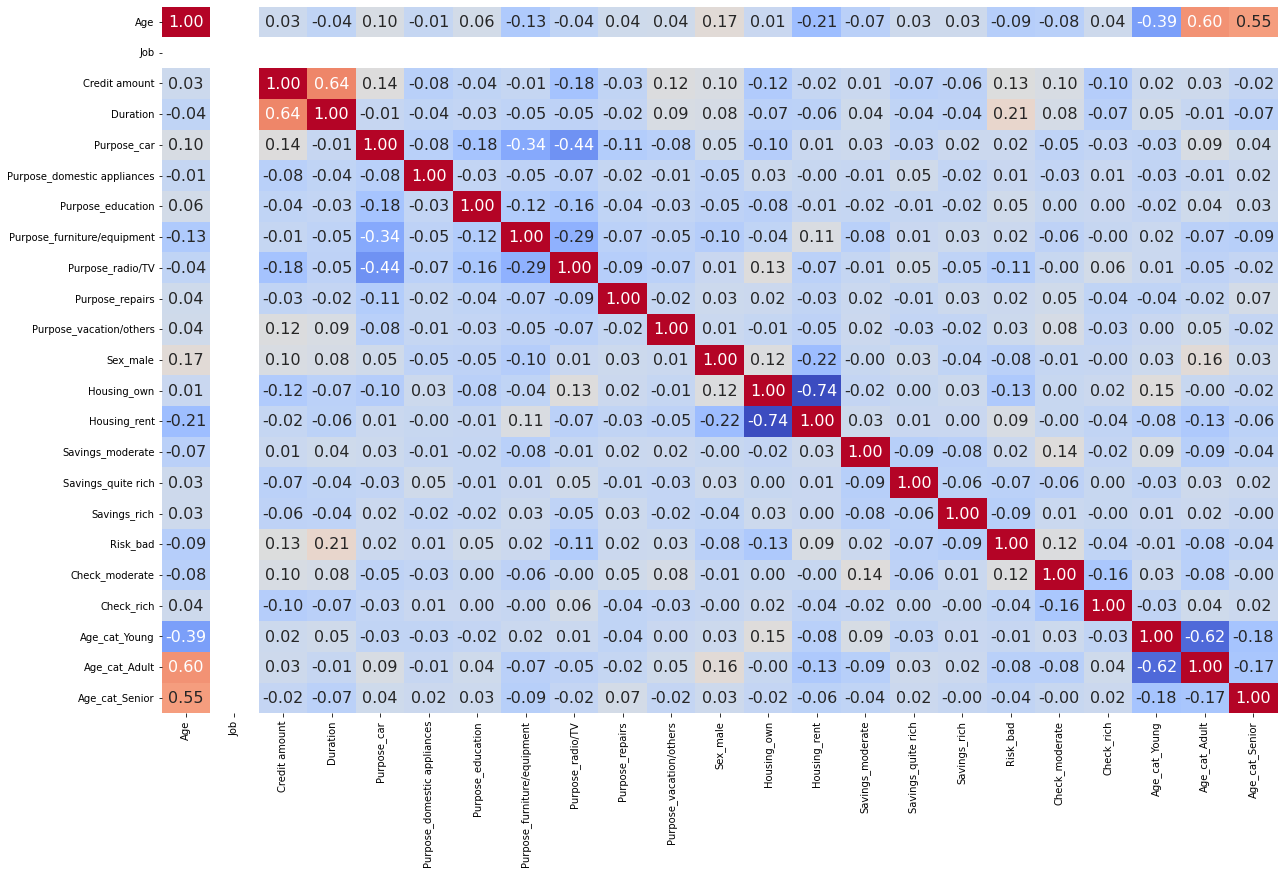

In [ ]:
plt.figure(figsize=(20,13))
sns.heatmap(df.corr(),
            cmap='coolwarm',
            annot=True,
            fmt=".2f",
            annot_kws={'size':16},
            cbar=False)

# **Modelling**

In [ ]:
#Creating the X and y variables
X = df.drop('Risk_bad', 1).values
y = df["Risk_bad"].values

# Spliting X and y into train and test version
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=42)

LGR: 0.216377 (0.075616)
LDA: 0.274640 (0.102902)
KNN: 0.286142 (0.089302)
CART: 0.425972 (0.088133)
NB: 0.548899 (0.123049)
RF: 0.269363 (0.087069)
SVM: 0.066026 (0.044179)
XGBM: 0.331140 (0.065788)
LGBM: 0.318689 (0.080534)


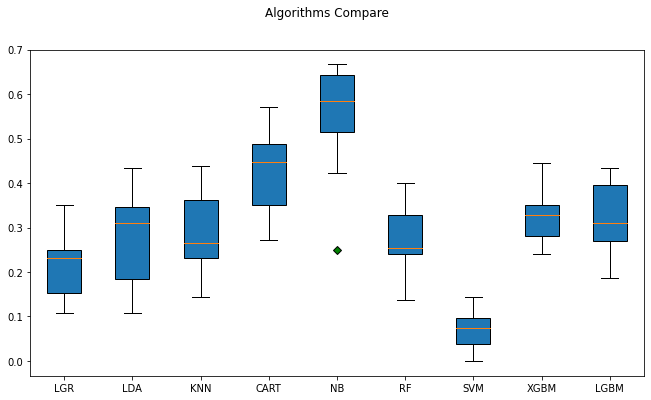

In [ ]:
# to feed the random state
seed = 7

# prepare models
models = []
# models.append(('LR', LinearRegression()))
# models.append(('RDR', Ridge()))
# models.append(('LSSR', Lasso()))
# models.append(('ER', ElasticNet()))
models.append(('LGR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('RF', RandomForestClassifier()))
models.append(('SVM', SVC(gamma='auto')))
models.append(('XGBM', XGBClassifier()))
models.append(('LGBM', LGBMClassifier()))


# evaluate each model in turn
results = []
names = []
scoring = 'recall'

for name, model in models:
        kfold = KFold(n_splits=10, random_state=seed, shuffle= True)
        cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
        results.append(cv_results)
        names.append(name)
        msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
        print(msg)
        
# boxplot algorithm comparison
fig = plt.figure(figsize=(11,6))
fig.suptitle('Algorithms Compare')
ax = fig.add_subplot(111)
green_diamond = dict(markerfacecolor='g', marker='D')
plt.boxplot(results, flierprops=green_diamond, patch_artist=True)
ax.set_xticklabels(names)
plt.show()

This code is performing a 10-fold cross-validation on a set of machine learning models, evaluating their performance using a given scoring metric.

Let's go through the code line by line:

* for name, model in models:: This is a loop that iterates over a list of model names and corresponding machine learning models. The name variable is a string that identifies the model, and model is the machine learning model itself.

* kfold = KFold(n_splits=10, random_state=seed, shuffle= True): Here, a KFold object is created with 10 splits (i.e., 10 folds) for cross-validation. The random_state parameter sets the seed for random number generation to ensure reproducibility, and the shuffle parameter specifies whether or not to shuffle the data before splitting it into folds.

* cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring): This line uses the cross_val_score function to perform cross-validation on the given machine learning model (model) using the training data (X_train and y_train), the KFold object (kfold) to split the data into folds, and the specified scoring metric (scoring). The cross_val_score function returns an array of scores, one for each fold.

* results.append(cv_results): The scores obtained for the current model are added to a list called results.

* names.append(name): The name of the current model is added to a list called names.

* msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std()): A message is created that summarizes the performance of the current model. The message includes the model name (name), the mean score across all folds (cv_results.mean()), and the standard deviation of the scores (cv_results.std()).

* print(msg): Finally, the message is printed to the console, providing a summary of the performance of the current model based on the given scoring metric.

This process is repeated for each model in the list, allowing for comparison of their performance using the same cross-validation strategy and scoring metric.

These output values represent the performance of different machine learning models using a 10-fold cross-validation strategy and a given scoring metric.

The values are reported in the format of "model name: mean score (standard deviation of scores)" for each model.

The Naive Bayes, Decision Tree, LightGBM and XGBoost models are seen as the best methods. Let's subject them to hyperparameter optimization using the verification method one by one.



**Gaussian Naive Bayes Model**

In [ ]:
from sklearn.utils import resample
from sklearn.metrics import roc_curve

GNB = GaussianNB()

# Fitting with train data
model = GNB.fit(X_train, y_train)

print("Primitive error evaluation accuracy score: ", model.score(X_train, y_train))

y_pred = model.predict(X_test)

print("Test predict accuracy score: ", accuracy_score(y_test,y_pred),"\n")

print("Confussion Matrix: \n", confusion_matrix(y_test, y_pred),"\n")

print("Classification report according to Test prediction: \n", classification_report(y_test, y_pred))

Primitive error evaluation accuracy score:  0.6773333333333333
Test predict accuracy score:  0.62 

Confussion Matrix: 
 [[122  56]
 [ 39  33]] 

Classification report according to Test prediction: 
               precision    recall  f1-score   support

           0       0.76      0.69      0.72       178
           1       0.37      0.46      0.41        72

    accuracy                           0.62       250
   macro avg       0.56      0.57      0.56       250
weighted avg       0.65      0.62      0.63       250



The code you provided above does not include hyperparameter optimization.

It is fitting a Gaussian Naive Bayes model (GNB) to the training data (X_train and y_train), printing the primitive error evaluation accuracy score, making predictions on the test data (X_test), printing the test predict accuracy score, and displaying the confusion matrix and classification report for the test predictions.

Hyperparameter optimization refers to the process of searching for the best set of hyperparameters for a given machine learning model. This typically involves using techniques such as grid search or randomized search to explore different combinations of hyperparameters and evaluate their performance using a validation set or cross-validation. The purpose of hyperparameter optimization is to improve the performance of the model on the test data by finding the optimal set of hyperparameters for the given task.

The Naive Bayes model seems to be the best method. Let's see ROC curve for predict probability

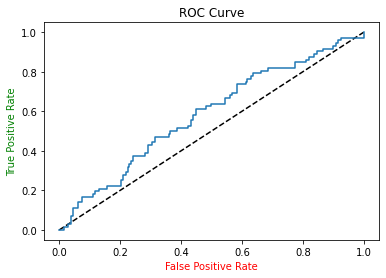

In [ ]:
#Predicting probability
y_pred_prob = model.predict_proba(X_test)[:,1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate', color="r")
plt.ylabel('True Positive Rate', color="g")
plt.title('ROC Curve')
plt.show()

**XGBOOST Model**

In [ ]:
xgb = XGBClassifier(random_state = 12345)

xgb_params = {
    "learning_rate": [0.01, 0.1, 0.2, 1],
    "min_samples_split": np.linspace(0.1, 0.5, 10),
    "max_depth":[3,5,8],
    "subsample":[0.5, 0.9, 1.0],
    "n_estimators": [100,1000]}

xgb_cv_model  = GridSearchCV(xgb,xgb_params, cv = 5, n_jobs = -1, verbose = 2).fit(X, y)   # cv=5 is not enough and this is for faster estimate

xgb_tuned = XGBClassifier(**xgb_cv_model.best_params_).fit(X,y)
cross_val_score(xgb_tuned, X, y, cv = 10).mean()

Fitting 5 folds for each of 720 candidates, totalling 3600 fits


KeyboardInterrupt: ignored

cv in GridSearchCV refers to the number of folds to use in cross-validation during the grid search process. In the code snippet, cv=5 indicates that 5-fold cross-validation will be used.

Cross-validation is a technique used to evaluate the performance of a machine learning model. It involves partitioning the dataset into multiple subsets or folds, training the model on several combinations of these folds, and evaluating its performance on the remaining fold(s). This process is repeated multiple times, with different combinations of folds used for training and evaluation in each iteration.

The GridSearchCV function is used to perform hyperparameter tuning for a given estimator (in this case, xgb) by exhaustively searching over a specified parameter grid. The cv parameter specifies the number of folds to be used in the cross-validation process for each combination of hyperparameters in the grid.

In summary, cv in GridSearchCV specifies the number of folds to be used in cross-validation during the hyperparameter tuning process.

This code performs hyperparameter tuning for an XGBoost classifier model (xgb) using GridSearchCV.

First, xgb is initialized with a specified random state. Then, a dictionary of hyperparameters to tune (xgb_params) is defined, including learning rate, minimum number of samples required to split a node, maximum depth of a tree, subsample ratio of columns when constructing each tree, and number of trees.

GridSearchCV is used to perform a grid search over the specified hyperparameters, using a 5-fold cross-validation strategy (cv=5) and parallelizing the search using all available CPU cores (n_jobs=-1). The best set of hyperparameters is chosen based on the mean score over the 5 folds.

Finally, a new XGBoost classifier model (xgb_tuned) is initialized with the best hyperparameters found by the grid search (xgb_cv_model.best_params_), and its performance is evaluated using 10-fold cross-validation (cross_val_score) with the mean score returned.







**LightGBM Model**

In [ ]:
# model tuning

lgbm = LGBMClassifier()
lgbm_params = {"learning_rate": [0.01, 0.03, 0.05, 0.1, 0.5],
               "n_estimators": [500, 1000, 1500],
               "max_depth": [3,5,8]}

#GridSearchCV method
gs_cv = GridSearchCV(lgbm,
                     lgbm_params,
                     cv=5,        # cv=5 is not enough and this is for faster estimate
                     n_jobs=-1,
                     verbose=2).fit(X_train, y_train)


lgbm_tuned = LGBMClassifier(**gs_cv.best_params_).fit(X, y)
cross_val_score(lgbm_tuned, X_test, y_test, cv=10).mean()

kfold = KFold(n_splits=10, random_state=123456,shuffle=True)
cv_results = cross_val_score(LGBMClassifier(), X_train, y_train, cv=kfold, scoring="accuracy")
cv_results.mean()

Fitting 5 folds for each of 45 candidates, totalling 225 fits


0.6799999999999999

This code performs hyperparameter tuning for a LightGBM classifier model (lgbm) using GridSearchCV.

First, lgbm is initialized without any hyperparameters. Then, a dictionary of hyperparameters to tune (lgbm_params) is defined, including learning rate, number of trees, and maximum depth of a tree.

GridSearchCV is used to perform a grid search over the specified hyperparameters, using a 5-fold cross-validation strategy (cv=5) and parallelizing the search using all available CPU cores (n_jobs=-1). The best set of hyperparameters is chosen based on the mean score over the 5 folds.

Finally, a new LightGBM classifier model (lgbm_tuned) is initialized with the best hyperparameters found by the grid search (gs_cv.best_params_), and its performance is evaluated using 10-fold cross-validation (cross_val_score) with the mean score returned.

Additionally, the code performs another cross-validation using KFold with 10 splits and a specified random state, evaluating the performance of an unoptimized LightGBM classifier model using the default hyperparameters. The mean score over the 10 folds is returned.

**Pipeline Method**

Select features according to the k highest scores and Principal Component Analysis(PCA) then we will apply Logistic Regression with feature union.

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest


features = []
features.append(('PCA', PCA(n_components=2)))
features.append(('Select_best', SelectKBest(k=6)))
feature_union = FeatureUnion(features)

# create pipeline
estimators = []
estimators.append(('Feature_union', feature_union))
estimators.append(('Logistic_regression', LogisticRegression()))
model = Pipeline(estimators)

# evaluate pipeline
seed = 7
kfold = KFold(n_splits=10, random_state=seed,shuffle=True)
results = cross_val_score(model, X_train, y_train, cv=kfold)
print(results.mean())

/usr/local/lib/python3.9/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning:

Features [1] are constant.

/usr/local/lib/python3.9/dist-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.9/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning:

Features [1] are constant.

/usr/local/lib/python3.9/dist-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.9/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning:

Features [1] are constant.

/usr/local/lib/python3.9/dist-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.9/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning:

Features [1] are c

0.7053333333333334


/usr/local/lib/python3.9/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning:

Features [1] are constant.

/usr/local/lib/python3.9/dist-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.9/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning:

Features [1] are constant.

/usr/local/lib/python3.9/dist-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.9/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning:

Features [1] are constant.

/usr/local/lib/python3.9/dist-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning:

invalid value encountered in true_divide



In [ ]:
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("Test predict accuracy score: {:.2f}".format(accuracy_score(y_test,y_pred)),"\n")

print("Confussion Matrix: \n", confusion_matrix(y_test, y_pred),"\n")

print("Weighted harmonic mean of precision according to Test prediction: ", fbeta_score(y_test, y_pred, beta=2))

Test predict accuracy score: 0.70 

Confussion Matrix: 
 [[161  17]
 [ 58  14]] 

Weighted harmonic mean of precision according to Test prediction:  0.219435736677116


/usr/local/lib/python3.9/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning:

Features [1] are constant.

/usr/local/lib/python3.9/dist-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning:

invalid value encountered in true_divide



In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest


features = []
features.append(('PCA', PCA(n_components=2)))
features.append(('Select_best', SelectKBest(k=6)))
feature_union = FeatureUnion(features)

# create pipeline
estimators = []
estimators.append(('Feature_union', feature_union))
estimators.append(('GaussianNB',GaussianNB()))
model = Pipeline(estimators)

# evaluate pipeline
seed = 7
kfold = KFold(n_splits=10, random_state=seed,shuffle=True)
results = cross_val_score(model, X_train, y_train, cv=kfold)
print(results.mean())

0.6786666666666668


/usr/local/lib/python3.9/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning:

Features [1] are constant.

/usr/local/lib/python3.9/dist-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.9/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning:

Features [1] are constant.

/usr/local/lib/python3.9/dist-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.9/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning:

Features [1] are constant.

/usr/local/lib/python3.9/dist-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.9/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning:

Features [1] are c

This code creates a machine learning pipeline that selects the best features using Principal Component Analysis (PCA) and the SelectKBest algorithm, then applies Logistic Regression to the selected features.

First, the code creates a list of feature transformers that will be used in the pipeline. The first transformer is PCA, which reduces the dimensionality of the input data by projecting it onto a lower-dimensional space while preserving as much variance as possible. The second transformer is SelectKBest, which selects the k highest scoring features according to a given scoring function.

Next, the FeatureUnion class is used to combine the feature transformers into a single transformer that can be used in the pipeline.

The code then creates a list of estimators, which includes the feature union transformer and the LogisticRegression model. These estimators are combined into a pipeline using the Pipeline class.

Finally, the pipeline is evaluated using k-fold cross-validation with 10 folds. The results.mean() method is used to calculate the mean of the evaluation metrics across all folds.

In [ ]:
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("Test predict accuracy score: {:.2f}".format(accuracy_score(y_test,y_pred)),"\n")

print("Confussion Matrix: \n", confusion_matrix(y_test, y_pred),"\n")

print("Weighted harmonic mean of precision according to Test prediction: ", fbeta_score(y_test, y_pred, beta=2))

Test predict accuracy score: 0.66 

Confussion Matrix: 
 [[148  30]
 [ 55  17]] 

Weighted harmonic mean of precision according to Test prediction:  0.2537313432835821


/usr/local/lib/python3.9/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning:

Features [1] are constant.

/usr/local/lib/python3.9/dist-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning:

invalid value encountered in true_divide



The code is demonstrating the use of feature selection and dimensionality reduction techniques in a machine learning pipeline using scikit-learn.

In this specific code, the pipeline includes two feature selection techniques: SelectKBest, which selects the k highest-scoring features according to a given score function, and PCA, which performs dimensionality reduction by projecting the data onto a lower-dimensional space while retaining the maximum amount of variance.

After the feature selection and dimensionality reduction steps, the pipeline applies logistic regression as the final model for classification.

The accuracy score measures the proportion of correctly classified samples out of all samples in the test set. The confusion matrix shows the true and predicted class labels for each sample in the test set. The weighted harmonic mean of precision, with beta=2, is a measure of precision that takes into account both false positives and false negatives. It is a way to balance between precision and recall, where higher beta values put more weight on recall.

To get high accuracy test with CV =10

**Random Forest Classifier**

In [ ]:
rf = RandomForestClassifier(max_depth=None, max_features=10, n_estimators=15, random_state=2)

#trainning with the best params
rf.fit(X_train, y_train)

RandomForestClassifier(max_features=10, n_estimators=15, random_state=2)

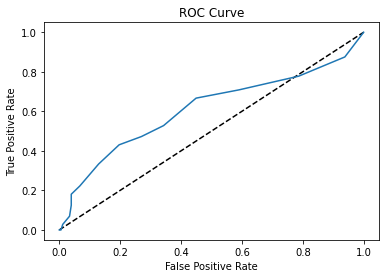

AUC score:  0.6094725343320848


In [ ]:
from sklearn.utils import resample
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

#Predicting proba
y_pred_prob = rf.predict_proba(X_test)[:,1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
auc_score = roc_auc_score(y_test, y_pred_prob)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('AUC score: ',auc_score)

**Fairness measures using Gender**

In [ ]:
#Creating the X and y variables
X = df.drop('Risk_bad', 1).values
y = df["Risk_bad"].values

# Creating the X without gender attributes
XX = df.drop(['Risk_bad','Sex_male'],1).values

# Spliting X and y into train and test version
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=42)
# Spliting X and y into train and test version for data without gender attributes
XX_train, XX_test, yy_train, yy_test = train_test_split(XX, y, test_size = 0.25, random_state=42)

## Train model without gender attributes
rf_ac = RandomForestClassifier(max_depth=None, max_features=10, n_estimators=15, random_state=2)
rf_ac.fit(XX_train, yy_train)

test_df = pd.DataFrame(X_test, columns=df.columns.drop('Risk_bad'))
test_df['Risk_bad'] = y_test
test_df.head()

,Age,Job,Credit amount,Duration,Purpose_car,Purpose_domestic appliances,Purpose_education,Purpose_furniture/equipment,Purpose_radio/TV,Purpose_repairs,Purpose_vacation/others,Sex_male,Housing_own,Housing_rent,Savings_moderate,Savings_quite rich,Savings_rich,Check_moderate,Check_rich,Age_cat_Young,Age_cat_Adult,Age_cat_Senior,Risk_bad
0,24.000,2.000,3190.000,18.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1
1,35.000,2.000,4380.000,18.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,1.000,0.000,1.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0
2,32.000,2.000,2325.000,24.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,1.000,0.000,1.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0
3,23.000,2.000,1297.000,12.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,1.000,0.000,1.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0
4,35.000,2.000,7253.000,33.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0


In [ ]:
# Get male from Testset
test_m = test_df[test_df['Sex_male'] == 1]

#Creating the X and y variables
X_test_m = test_m.drop('Risk_bad', 1).values
y_test_m = test_m["Risk_bad"].values
#Testing the model for male group
y_pred_m = rf.predict(X_test_m)


print(accuracy_score(y_test_m,y_pred_m))
print("\n")
tn_m, fp_m, fn_m, tp_m = confusion_matrix(y_test_m, y_pred_m).ravel()
print(confusion_matrix(y_test_m, y_pred_m))

0.711864406779661


[[112  15]
 [ 36  14]]


In [ ]:
# Get female from Testset
test_f = test_df[test_df['Sex_male'] == 0]

#Creating the X and y variables
X_test_f = test_f.drop('Risk_bad', 1).values
y_test_f = test_f["Risk_bad"].values
#Testing the model for male group
y_pred_f = rf.predict(X_test_f)

#Testing the model with and without gender attributes
y_pred = rf.predict(X_test)
y_pred_ac = rf_ac.predict(XX_test)

# calculate anti-classification
data_len = y_pred.shape[0]
y_pred = y_pred.astype('int16')
y_pred_ac = y_pred_ac.astype('int16')
dist = sum(np.abs(y_pred - y_pred_ac))
ac_metric = dist / data_len

# Verify the results obtained
print(accuracy_score(y_test_f,y_pred_f))
print("\n")
tn_f, fp_f, fn_f, tp_f = confusion_matrix(y_test_f, y_pred_f).ravel()
print(confusion_matrix(y_test_f, y_pred_f))

0.726027397260274


[[43  8]
 [12 10]]


In [ ]:
group_fairness_base = abs((tp_m+fp_m)/len(y_test_m) - (tp_f+fp_f)/len(y_test_f))
separation_base = abs(tp_m/(fn_m+tp_m)-tp_f/(fn_f+tp_f))
print("\n")
print("Anti-classification Metric: ",ac_metric)
print("Group Fairness Measure:", group_fairness_base)
print("Separation Measure:", separation_base)



Anti-classification Metric:  0.128
Group Fairness Measure: 0.0827335345561489
Separation Measure: 0.1745454545454545


The code is calculating two fairness measures: Group Fairness Measure and Separation Measure.

Group Fairness Measure is based on the difference between the false positive rate (FPR) of the protected group (in this case, women) and the FPR of the unprotected group (in this case, men). A smaller value of this measure indicates a more equitable model, where the difference between FPRs for the two groups is smaller.

Separation Measure is based on the difference between the true positive rate (TPR) of the protected group and the TPR of the unprotected group. A smaller value of this measure indicates a more equitable model, where the difference between TPRs for the two groups is smaller.

The code calculates the baseline values for these measures (group_fairness_base and separation_base) and prints them along with another fairness measure called Anti-classification Metric (ac_metric).

The Anti-classification Metric, Group Fairness Measure, and Separation Measure are used to evaluate the fairness of a machine learning model in terms of its treatment of different subgroups in the dataset. Specifically:

The Anti-classification Metric measures the degree to which the model has relied on sensitive attributes (such as race or gender) to make predictions, and it is used to ensure that sensitive attributes are not given unfair weight in the decision-making process.

The Group Fairness Measure evaluates whether the model is performing similarly for different subgroups defined by sensitive attributes. This measure is used to identify and address any potential biases in the model that may disproportionately affect certain groups.

The Separation Measure evaluates the degree to which the model separates the positive and negative examples for different subgroups defined by sensitive attributes. This measure is used to identify cases where the model is more likely to classify examples from one group as positive and examples from another group as negative, which can result in unfair treatment of certain groups.

Overall, these metrics are important for ensuring that machine learning models are fair and unbiased, and do not unfairly disadvantage certain groups of people.

**Improved Fairness for Gender**

In [ ]:
test_df = pd.DataFrame(X_test, columns=df.columns.drop('Risk_bad'))
test_df['Risk_bad'] = y_test
test_df.head()

,Age,Job,Credit amount,Duration,Purpose_car,Purpose_domestic appliances,Purpose_education,Purpose_furniture/equipment,Purpose_radio/TV,Purpose_repairs,Purpose_vacation/others,Sex_male,Housing_own,Housing_rent,Savings_moderate,Savings_quite rich,Savings_rich,Check_moderate,Check_rich,Age_cat_Young,Age_cat_Adult,Age_cat_Senior,Risk_bad
0,24.000,2.000,3190.000,18.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1
1,35.000,2.000,4380.000,18.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,1.000,0.000,1.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0
2,32.000,2.000,2325.000,24.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,1.000,0.000,1.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0
3,23.000,2.000,1297.000,12.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,1.000,0.000,1.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0
4,35.000,2.000,7253.000,33.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0


In [ ]:
## Train model without gender attributes
XX = df.drop(['Risk_bad','Sex_male'],1).values
XX_train, XX_test, yy_train, yy_test = train_test_split(XX, y, test_size = 0.25, random_state=42)

rf_ac = RandomForestClassifier(max_depth=None, max_features=10, n_estimators=15, random_state=2)
rf_ac.fit(XX_train, yy_train)
y_pred_ac = rf_ac.predict(XX_test)

## train model with masking augmentation
import random
random.seed(10)
random_idx_list = random.sample(range(len(X)),len(X)//2)
df_X = df.drop('Risk_bad', 1)
df_X['Sex_male'][random_idx_list] = 0.5
X = df_X.values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=42)

rf = RandomForestClassifier(max_depth=None, max_features=10, n_estimators=15, random_state=2)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

## calculate anti-classification
data_len = y_pred.shape[0]
y_pred = y_pred.astype('int16')
y_pred_ac = y_pred_ac.astype('int16')
dist = sum(np.abs(y_pred - y_pred_ac))
ac_metric = dist / data_len

## print anti-classfication metric
print("Anti-classification Metric with masking augmentation: ",ac_metric)

Anti-classification Metric with masking augmentation:  0.116


In the code snippet provided, the model is trained with masking augmentation. Masking augmentation is a type of data augmentation technique that involves randomly masking or replacing some parts of the input data with noise or other values. In this case, the code randomly replaces the 'Sex_male' feature of half of the data samples with the value 0.5.

The purpose of using masking augmentation is to improve the robustness and generalization ability of the model. By introducing noise and variability in the training data, the model can learn to be more resilient to variations in the input data and less prone to overfitting.

After training the model with masking augmentation, the code calculates the anti-classification metric, which measures the degree of imbalance or unfairness in the model's predictions across different groups. The lower the anti-classification metric, the more balanced and fair the model's predictions are across different subgroups of the data.

In [ ]:
def predict_w_thresh(trained_model,test_set,thresh):
    #Testing the model for male group
    y_pred_proba = trained_model.predict_proba(test_set)
    y_pred_proba_true = y_pred_proba[:,1]
    y_pred = [1 if proba > thresh else 0 for proba in y_pred_proba_true]
    return y_pred

In [ ]:
# Get male from Testset
test_m = test_df[test_df['Sex_male'] == 1]
# Get female from Testset
test_f = test_df[test_df['Sex_male'] == 0]

#Creating the X and y variables
X_test_m = test_m.drop('Risk_bad', 1).values
y_test_m = test_m["Risk_bad"].values
#Creating the X and y variables
X_test_f = test_f.drop('Risk_bad', 1).values
y_test_f = test_f["Risk_bad"].values

thresh_m_lst = np.linspace(0, 1, 11)
thresh_f_lst = np.linspace(0, 1, 11)

group_fairness_lst = []
separation_lst = []
for thresh_m in thresh_m_lst[1:-1]:
    for thresh_f in thresh_f_lst[1:-1]:
        if thresh_m == thresh_f:
            continue
        y_pred_m = predict_w_thresh(rf, X_test_m, thresh_m)
        y_pred_f = predict_w_thresh(rf, X_test_f, thresh_f)

        tn_m, fp_m, fn_m, tp_m = confusion_matrix(y_test_m, y_pred_m).ravel()
        tn_f, fp_f, fn_f, tp_f = confusion_matrix(y_test_f, y_pred_f).ravel()
        
        group_fairness = abs((tp_m+fp_m)/len(y_test_m) - (tp_f+fp_f)/len(y_test_f))
        separation = abs(tp_m/(fn_m+tp_m)-tp_f/(fn_f+tp_f))
        accuracy = (tp_m+tn_m+tp_f+tn_f)/(len(y_test_m) + len(y_test_f))
        
        
        if group_fairness <= group_fairness_base:
            print("############ Male thresh", thresh_m, 'Female thresh', thresh_f, '###############')
            print(confusion_matrix(y_test_m, y_pred_m))
            print(confusion_matrix(y_test_f, y_pred_f))
            print("Group Fairness Measure:", group_fairness)
            #print("Separation Measure:", separation)
            print("Accuracy:", accuracy)
            print("\n")

############ Male thresh 0.2 Female thresh 0.30000000000000004 ###############
[[66 61]
 [22 28]]
[[31 20]
 [ 6 16]]
Group Fairness Measure: 0.009674173825555354
Accuracy: 0.564


############ Male thresh 0.30000000000000004 Female thresh 0.4 ###############
[[86 41]
 [27 23]]
[[38 13]
 [12 10]]
Group Fairness Measure: 0.04651342775326989
Accuracy: 0.628


############ Male thresh 0.4 Female thresh 0.5 ###############
[[106  21]
 [ 34  16]]
[[45  6]
 [15  7]]
Group Fairness Measure: 0.03095735624177695
Accuracy: 0.696


############ Male thresh 0.5 Female thresh 0.6000000000000001 ###############
[[114  13]
 [ 37  13]]
[[49  2]
 [16  6]]
Group Fairness Measure: 0.03730361427134124
Accuracy: 0.728


############ Male thresh 0.5 Female thresh 0.7000000000000001 ###############
[[114  13]
 [ 37  13]]
[[49  2]
 [17  5]]
Group Fairness Measure: 0.05100224440832754
Accuracy: 0.724


############ Male thresh 0.6000000000000001 Female thresh 0.5 ###############
[[119   8]
 [ 40  10]]
[[45  6]


In [ ]:
# Get male from Testset
test_m = test_df[test_df['Sex_male'] == 1]
# Get female from Testset
test_f = test_df[test_df['Sex_male'] == 0]

#Creating the X and y variables
X_test_m = test_m.drop('Risk_bad', 1).values
y_test_m = test_m["Risk_bad"].values
#Creating the X and y variables
X_test_f = test_f.drop('Risk_bad', 1).values
y_test_f = test_f["Risk_bad"].values

thresh_m_lst = np.linspace(0, 1, 11)
thresh_f_lst = np.linspace(0, 1, 11)

group_fairness_lst = []
separation_lst = []
for thresh_m in thresh_m_lst[1:-1]:
    for thresh_f in thresh_f_lst[1:-1]:
        if thresh_m == thresh_f:
            continue
        y_pred_m = predict_w_thresh(rf, X_test_m, thresh_m)
        y_pred_f = predict_w_thresh(rf, X_test_f, thresh_f)

        tn_m, fp_m, fn_m, tp_m = confusion_matrix(y_test_m, y_pred_m).ravel()
        tn_f, fp_f, fn_f, tp_f = confusion_matrix(y_test_f, y_pred_f).ravel()
        
        group_fairness = abs((tp_m+fp_m)/len(y_test_m) - (tp_f+fp_f)/len(y_test_f))
        separation = abs(tp_m/(fn_m+tp_m)-tp_f/(fn_f+tp_f))
        accuracy = (tp_m+tn_m+tp_f+tn_f)/(len(y_test_m) + len(y_test_f))
        
        
        if separation <= separation_base:
            print("############ Male thresh", thresh_m, 'Female thresh', thresh_f, '###############')
            print(confusion_matrix(y_test_m, y_pred_m))
            print(confusion_matrix(y_test_f, y_pred_f))
            #print("Group Fairness Measure:", group_fairness)
            print("Separation Measure:", separation)
            print("Accuracy:", accuracy)
            print("\n")

############ Male thresh 0.1 Female thresh 0.2 ###############
[[33 94]
 [ 8 42]]
[[25 26]
 [ 4 18]]
Separation Measure: 0.021818181818181737
Accuracy: 0.472


############ Male thresh 0.1 Female thresh 0.30000000000000004 ###############
[[33 94]
 [ 8 42]]
[[31 20]
 [ 6 16]]
Separation Measure: 0.11272727272727268
Accuracy: 0.488


############ Male thresh 0.2 Female thresh 0.30000000000000004 ###############
[[66 61]
 [22 28]]
[[31 20]
 [ 6 16]]
Separation Measure: 0.16727272727272724
Accuracy: 0.564


############ Male thresh 0.2 Female thresh 0.4 ###############
[[66 61]
 [22 28]]
[[38 13]
 [12 10]]
Separation Measure: 0.10545454545454552
Accuracy: 0.568


############ Male thresh 0.30000000000000004 Female thresh 0.4 ###############
[[86 41]
 [27 23]]
[[38 13]
 [12 10]]
Separation Measure: 0.00545454545454549
Accuracy: 0.628


############ Male thresh 0.30000000000000004 Female thresh 0.5 ###############
[[86 41]
 [27 23]]
[[45  6]
 [15  7]]
Separation Measure: 0.14181818181818184

**Feature Importance Discussion**

In [ ]:
import pandas as pd

# convert X_train to a DataFrame
df_train = pd.DataFrame(X_train, columns=df.drop('Risk_bad', 1).columns)

# get feature importances
feature_importance = pd.DataFrame()
feature_importance["feature"] = df_train.columns
feature_importance["importance"] = rf.feature_importances_
feature_importance = feature_importance.sort_values("importance", ascending=False)

print(feature_importance)


                        feature  importance
2                 Credit amount       0.281
0                           Age       0.211
3                      Duration       0.143
11                     Sex_male       0.065
4                   Purpose_car       0.035
17               Check_moderate       0.035
8              Purpose_radio/TV       0.034
12                  Housing_own       0.028
14             Savings_moderate       0.027
19                Age_cat_Young       0.019
13                 Housing_rent       0.017
15           Savings_quite rich       0.016
6             Purpose_education       0.015
20                Age_cat_Adult       0.015
7   Purpose_furniture/equipment       0.014
9               Purpose_repairs       0.013
18                   Check_rich       0.012
16                 Savings_rich       0.009
10      Purpose_vacation/others       0.006
21               Age_cat_Senior       0.005
5   Purpose_domestic appliances       0.002
1                           Job 